In [1]:
%matplotlib widget
import torch
import argparse
import gc
import random
import torch
from PIL import Image
from torchvision.transforms import PILToTensor
from torchvision import transforms
import torch.nn as nn 
from torch.nn import functional as F
import numpy as np
import torch
import matplotlib.pyplot as plt

from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst, ROADLeastRelevantFirst
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget

torch.cuda.is_available()
torch.cuda.set_device(3)

In [ ]:


filelist = ['./test_imgs/1d4133f5bc7af193.png', './test_imgs/ff5182599937c1ec.png','/home/yaozhu/OOD_Detection/ImageNet1000/ed3573d0c197fbaf.png','/home/yaozhu/OOD_Detection/ImageNet1000/ea65c0ff71e7ceb3.png',"/home/yaozhu/OOD_Detection/ImageNet1000/7c754696067fdfa9.png"]

###### Choose the idx of the test image #####################
index = 0

In [ ]:
#######################
####Load the model#####
#######################

from timm.models import create_model
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import timm
model = timm.create_model('tiny_vit_21m_224.in1k', checkpoint_path="shared_models/tiny_vit_21m_224.in1k.bin")

model = model.cuda()
model = model.eval()

total = sum([param.nelement() for param in model.parameters()])
print("Number of parameter: %.2fM" % (total/1e6))

config = resolve_data_config({}, model=model)
transform = create_transform(**config)
print(transform)

Number of parameter: 21.20M
Compose(
    Resize(size=235, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)


In [4]:
#####################################
### Load the test image #############
#####################################
imgtensors = []
imglist = []
img_size = 224
for filename in filelist:
    img = Image.open(filename).convert('RGB')
    img = img.resize((img_size, img_size))
    imglist.append(img)

for filename in filelist:
    img = Image.open(filename).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).cuda()
    imgtensors.append(img_tensor)
imgtensors = torch.cat(imgtensors, dim=0)
print(imgtensors.shape)
with torch.no_grad():
    ft = model.forward_features(imgtensors)#.permute(0,3,1,2)
    
print(ft.shape)
gc.collect()
torch.cuda.empty_cache()

torch.Size([3, 3, 224, 224])
torch.Size([3, 576, 7, 7])


In [5]:
#########################################################################################################################
# The code in this module consists of two parts: one part represents the mapping from the model's dense space features
# to the output classification results, while the other part simply represents the operations between the dense features 
# and the classification layer. Note that different models may need to modify this part according to their structures.
#########################################################################################################################


class predict_model(nn.Module): 
    def __init__(self,head,norm):
        super(predict_model, self).__init__()
        self.fc = head
        self.norm = norm
        self.flatten = nn.Flatten(1)
    def forward(self,x):
        x = x.reshape([x.shape[0],x.shape[1],x.shape[2]*x.shape[3]])
        out = torch.mean(x,dim=2,keepdim=True).unsqueeze(3)
        out = self.norm(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out

    def forward_threshold(self,x, threshold=0.4):
        x = x.reshape([x.shape[0],x.shape[1],x.shape[2]*x.shape[3]])
        out = torch.mean(x,dim=2,keepdim=True).unsqueeze(3)
        out = self.norm(out)
        out = self.flatten(out)
        out = out.clip(max=threshold)
        out = self.fc(out)
        return out
    
    

class feature_model(nn.Module): ### a simple NN network
    def __init__(self,norm):
        super(feature_model, self).__init__()
        self.norm = norm
        self.flatten = nn.Flatten(1)        
    
    def forward(self,x):
        outa = {}
        x = x.reshape([x.shape[0],x.shape[1],x.shape[2]*x.shape[3]])
        out = torch.mean(x,dim=2,keepdim=True).unsqueeze(3)
        out = self.norm(out)
        outa['avgpool'] = self.flatten(out)
        return outa

prem = predict_model(head=model.head.fc,norm=model.head.norm)
feat_exp = feature_model(norm=model.head.norm)



In [6]:
############################################################################################
## The mask on the spatial features, which is needed in calculating Shapley value.
############################################################################################


feature_size = 7
masks_list = []
for i in range(feature_size*feature_size):
    masks_list.append(torch.zeros([feature_size,feature_size]).unsqueeze(0))
masks_list = torch.cat(masks_list, dim=0)
# print(masks_list.shape)
for i in range(feature_size):
    for j in range(feature_size):
        masks_list[i*feature_size+j][i][j]=1
masks_list = masks_list.bool()


In [7]:
##########################################
#### The prediction results of the model.
##########################################

predict_org = torch.nn.functional.softmax(model(imgtensors[index].unsqueeze(0)).cuda(),dim=1)
pred_image_class = int(torch.argmax(predict_org))
maxoutput = predict_org.max()

print(pred_image_class,maxoutput)

140 tensor(0.8620, device='cuda:3', grad_fn=<MaxBackward1>)


In [8]:
########################################
## Import the Shapley calculation module
########################################

import sys
sys.path.append("./spatial_main_fast")
from spatial_explainer import *

In [9]:

image_norm = transforms.Compose([
    transforms.ToTensor(),
])

###################################################################################
### Get the dense features and calculate the Shapley value of each spatial feature
###################################################################################
input_image_copy = ft[index].cpu().detach()
auc_mask, shap_list, shap_arg = spatial_shap(prem,input_image_copy,pred_image_class,masks_list,model.head.fc,feat_exp,image_norm=image_norm,lr=0.001,mc=7000,epochs=50) #,lr=0.001

In [ ]:
#########################################
### Draw the heatmap of the attention ###
##########################################
shap_attention = shap_list.reshape(1,1,feature_size,feature_size)
shap_attention = torch.tensor(shap_attention)
shap_attention = (shap_attention - shap_attention.mean())/shap_attention.std()
shap_attention = torch.exp2(shap_attention/2)

import torch.nn.functional as F
shap_attention = F.interpolate(shap_attention, size=((224,224)), mode='bicubic', align_corners=True).squeeze(0).squeeze(0)

activation_map_ours = shap_attention.unsqueeze(0).numpy()

input_t = imgtensors[index].unsqueeze(0).requires_grad_(True)
label_m = [ClassifierOutputSoftmaxTarget(pred_image_class)]  #ClassifierOutputSoftmaxTarget


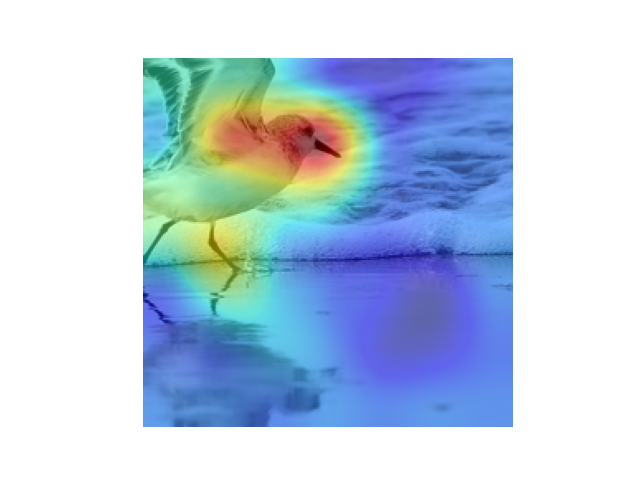

In [11]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(imglist[index]) ; plt.axis('off')
plt.imshow(255 * shap_attention.numpy(), alpha=0.5, cmap='jet')
plt.show()

140


/tmp/ipykernel_1917712/1256959090.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  activation_map_sg_ = torch.tensor(activation_map[0][0])


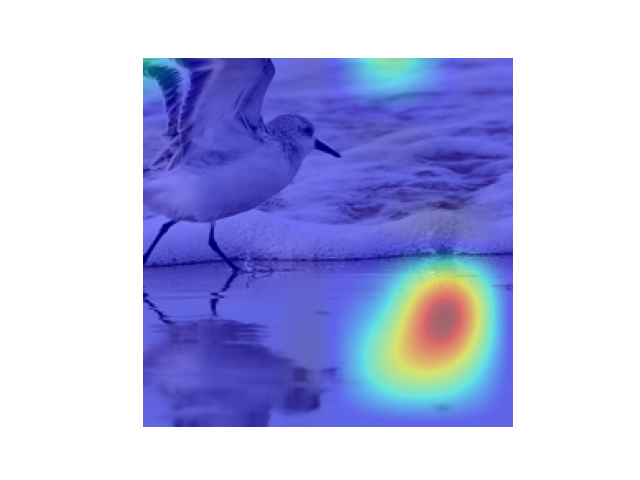

In [ ]:
#######################################################################################################
###### Get the attention heatmap of the conventional channel-based feature attribution method ########
#######################################################################################################

from torchcam.methods import ScoreCAM, SmoothGradCAMpp
cam_extractor = ScoreCAM(model.eval().cuda())
model.eval()
out = model(imgtensors[index].unsqueeze(0).cuda())
print(out.cpu().squeeze(0).argmax().item())
# Retrieve the CAM by passing the class index and the model output
activation_map_score = cam_extractor(out.cpu().squeeze(0).argmax().item(), out)
# print(len(activation_map))

activation_map_score_ = torch.tensor(activation_map_score[0][0])
activation_map_score_ = F.interpolate(activation_map_score_.unsqueeze(0).unsqueeze(0), size=((224,224)), mode='bicubic', align_corners=True).detach().cpu()
activation_map_score = activation_map_score_.squeeze(0).numpy()

plt.figure()
plt.imshow(imglist[index]) ; plt.axis('off')
plt.imshow(255 * activation_map_score_.squeeze(0).squeeze(0).numpy(), alpha=0.5, cmap='jet')
plt.show()

In [ ]:
model2 = timm.models.create_model('resnet50', pretrained=True, pretrained_cfg=pretrained_cfg)
model2 = model2.cuda()
model2 = model2.eval()
cam_extractor = SmoothGradCAMpp(model2.eval().cuda())

model2.eval()
out = model2(imgtensors[index].unsqueeze(0).cuda())
print(out.cpu().squeeze(0).argmax().item())
# Retrieve the CAM by passing the class index and the model output
activation_map_sg = cam_extractor(out.cpu().squeeze(0).argmax().item(), out)
# print(len(activation_map))

activation_map_sg_ = torch.tensor(activation_map_sg[0][0])
activation_map_sg_ = F.interpolate(activation_map_sg_.unsqueeze(0).unsqueeze(0), size=((224,224)), mode='bicubic', align_corners=True).detach().cpu()
activation_map_sg = activation_map_sg_.squeeze(0).numpy()

plt.figure()
plt.imshow(imglist[index]) ; plt.axis('off')
plt.imshow(255 * activation_map_sg_.squeeze(0).squeeze(0).numpy(), alpha=0.5, cmap='jet')
plt.show()

In [ ]:
###############################################################################################################
## Evaluation of the local faithfulness of different methods follow the ROAD protocol (MoRF and LeRF).
#############################################################################################################


sg_most_list = []
for i_p in range(50):
    percentile = 100 - i_p*2
    cam_metric = ROADMostRelevantFirst(percentile=percentile)
    scores, visualizations =cam_metric(input_t, activation_map_sg, label_m, model, return_visualization=True)
    score = maxoutput + scores[0]
    sg_most_list.append(score)

sg_least_list = []
for i_p in range(50):
    percentile = 100 - i_p*2
    cam_metric = ROADLeastRelevantFirst(percentile=percentile)
    scores, visualizations =cam_metric(input_t, activation_map_sg, label_m, model, return_visualization=True)
    score = maxoutput + scores[0]
    sg_least_list.append(score)
    

score_most_list = []
for i_p in range(50):
    percentile = 100 - i_p*2
    cam_metric = ROADMostRelevantFirst(percentile=percentile)
    scores, visualizations =cam_metric(input_t, activation_map_score, label_m, model, return_visualization=True)
    score = maxoutput + scores[0]
    score_most_list.append(score)

score_least_list = []
for i_p in range(50):
    percentile = 100 - i_p*2
    cam_metric = ROADLeastRelevantFirst(percentile=percentile)
    scores, visualizations =cam_metric(input_t, activation_map_score, label_m, model, return_visualization=True)
    score = maxoutput + scores[0]
    score_least_list.append(score)
    
    
ours_most_list = []
for i_p in range(50):
    percentile = 100 - i_p*2
    cam_metric = ROADMostRelevantFirst(percentile=percentile)
    scores, visualizations =cam_metric(input_t, activation_map_ours, label_m, model, return_visualization=True)
    score = maxoutput + scores[0]
    ours_most_list.append(score)

ours_least_list = []
for i_p in range(50):
    percentile = 100 - i_p*2
    cam_metric = ROADLeastRelevantFirst(percentile=percentile)
    scores, visualizations =cam_metric(input_t, activation_map_ours, label_m, model, return_visualization=True)
    score = maxoutput + scores[0]
    ours_least_list.append(score)

Ours 0.4215666806697845
SmoothGradCAM++ 0.6679877185821533


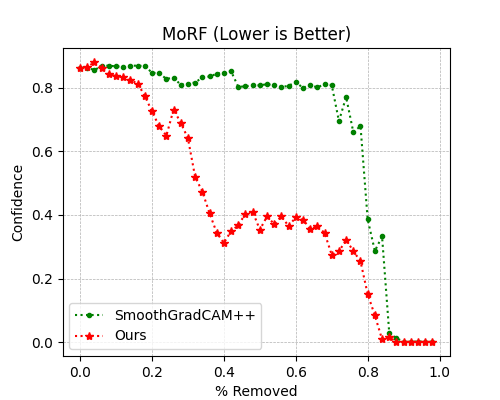

In [ ]:
import matplotlib
import numpy as np
from  matplotlib import pyplot as plt
plt.figure(figsize=(5,4))
x = [(i)/50 for i in range(50)]
y = [i.cpu().detach() for i in ours_most_list]
y2 = [i.cpu().detach() for i in sg_most_list]
y3 = [i.cpu().detach() for i in score_most_list]

plt.plot(x, y3,'o:b',markersize=3, label = 'ScoreCAM')
plt.plot(x, y2,'o:g',markersize=3, label = 'SmoothGradCAM++')
plt.plot(x, y,'*:r', label = 'Ours')
plt.grid(linestyle = '--', linewidth = 0.5)
from numpy import trapz
print("Ours",trapz(y, x, dx=0.001))
print("SmoothGradCAM++",trapz(y2, x, dx=0.001))
print("ScoreCAM",trapz(y3, x, dx=0.001))
plt.xlabel('% Removed')
plt.title( 'MoRF (Lower is Better)')
plt.ylabel('Confidence')
plt.legend()
plt.show()

Ours 0.7946650493144988
SmoothGradCAM++ 0.39307379007339477


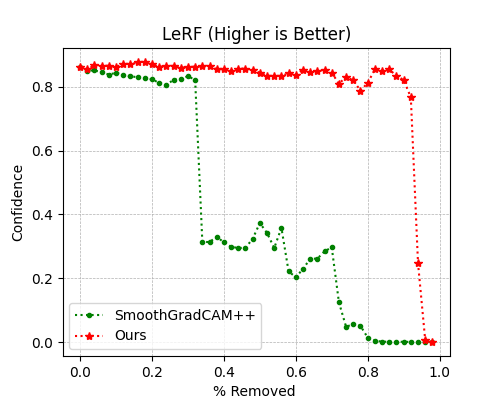

In [ ]:
import matplotlib
import numpy as np
from  matplotlib import pyplot as plt
#通用设置
plt.figure(figsize=(5,4))
#数据及线属性
x = [(i)/50 for i in range(50)]
y = [i.cpu().detach() for i in ours_least_list]
y2 = [i.cpu().detach() for i in sg_least_list]
y3 = [i.cpu().detach() for i in score_least_list]
plt.plot(x, y3,'o:b',markersize=3, label = 'ScoreCAM')
plt.plot(x, y2,'o:g',markersize=3, label = 'SmoothGradCAM++')
plt.plot(x, y,'*:r', label = 'Ours')

print("Ours",trapz(y, x, dx=0.001))
print("SmoothGradCAM++",trapz(y2, x, dx=0.001))
print("ScoreCAM",trapz(y3, x, dx=0.001))

plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel('% Removed ')
plt.title('LeRF (Higher is Better)')
plt.ylabel('Confidence')
plt.legend()
plt.show()